In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Load and prepare the dataset
file_path = 'VIX0705.csv'  # 替換為你的文件路徑
df = pd.read_csv(file_path,parse_dates=['DATE'])

# Select the relevant columns
selected_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'KD', 'RSI', 'MACD']
data = df[selected_columns].values

# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset_multivariate(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step)])
        dataY.append(dataset[i + time_step, 3])  # 3 corresponds to 'CLOSE'
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset_multivariate(train_data, time_step)
X_test, y_test = create_dataset_multivariate(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(selected_columns))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(selected_columns))

# Transformer Block (no changes needed here)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae", "mape"])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 7)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 7)      14          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 7)      31751       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

KeyboardInterrupt: 

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluate the model on the test data
predictions = model.predict(X_test)

# To inverse transform y_test and predictions, we need to rescale them individually
# Create a new scaler for just the CLOSE values
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(train_data[:, 3].reshape(-1, 1))

# Inverse transform the predictions and true values to the original scale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler_y.inverse_transform(predictions)

# Calculate the metrics
mse = mean_squared_error(y_test_inv, predictions_inv)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions_inv)
mape = np.mean(np.abs((y_test_inv - predictions_inv) / y_test_inv)) * 100
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

51/51 [==============================] - 2s 41ms/step
MSE: 0.001573618567344011
RMSE: 0.03966886143241335
MAE: 0.02411955745756211
MAPE: 21.42122486930371


51/51 [==============================] - 2s 39ms/step


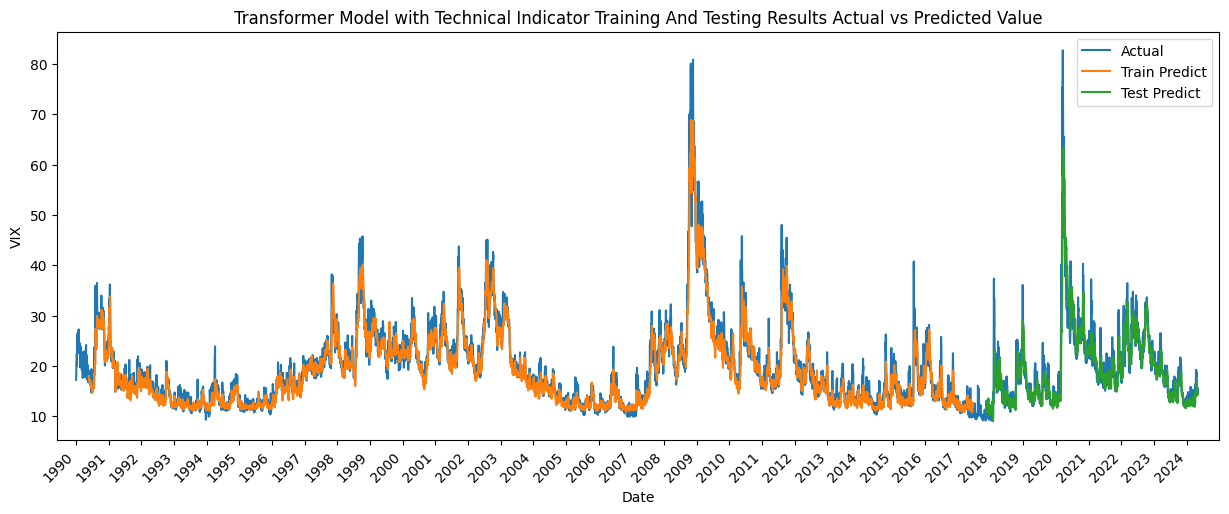

In [11]:
import matplotlib.dates as mdates
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit_transform(data[:, 3].reshape(-1, 1))  # 3 corresponds to 'CLOSE'
# 進行預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict2 = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 6))), axis=1))[:,0]
test_predict2 = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 6))), axis=1))[:,0]

# 準備繪圖數據
train_true = scaler.inverse_transform(train_data)[:, -1]
test_true = scaler.inverse_transform(test_data)[:, -1]

# 移動預測數據以進行繪圖
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict2)+time_step, -1] = train_predict2

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict2)+(time_step*2)+1:len(data)-1, -1] = test_predict2

# 準備繪圖數據，將預測值放回原始數據範圍
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((train_predict.shape[0], 6)), train_predict), axis=1))[:, -1]

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((test_predict.shape[0], 6)), test_predict), axis=1))[:, -1]



# 繪製圖表
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], data[:, 3], label='Actual')
plt.plot(df['DATE'], train_predict_plot[:, -1], label='Train Predict')
plt.plot(df['DATE'], test_predict_plot[:, -1], label='Test Predict')

# 設置x軸格式顯示年份並設置範圍
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.Timestamp('1989-06-01'), pd.Timestamp('2024-12-31')])

# 旋轉x軸標籤以提高可讀性
plt.gcf().autofmt_xdate(rotation=45)

plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Transformer Model with Technical Indicator Training And Testing Results Actual vs Predicted Value')
plt.legend()
plt.show()

51/51 [==============================] - 2s 39ms/step


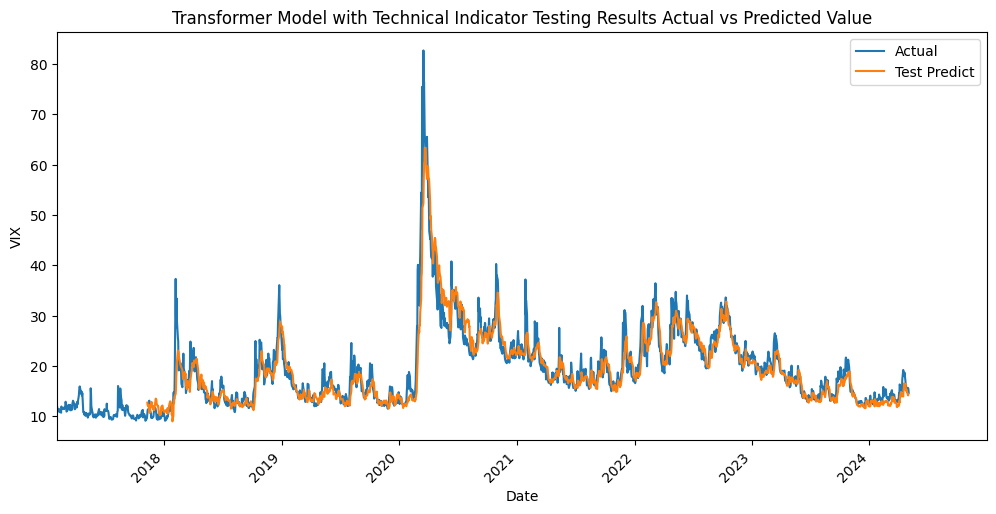

In [12]:
import matplotlib.dates as mdates
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit_transform(data[:, 3].reshape(-1, 1))  # 3 corresponds to 'CLOSE'
# 進行預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict2 = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 6))), axis=1))[:,0]
test_predict2 = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 6))), axis=1))[:,0]

# 準備繪圖數據
train_true = scaler.inverse_transform(train_data)[:, -1]
test_true = scaler.inverse_transform(test_data)[:, -1]

# 移動預測數據以進行繪圖
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict2)+time_step, -1] = train_predict2

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict2)+(time_step*2)+1:len(data)-1, -1] = test_predict2

# 準備繪圖數據，將預測值放回原始數據範圍
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((train_predict.shape[0], 6)), train_predict), axis=1))[:, -1]

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, -1] = scaler_y.inverse_transform(
    np.concatenate((np.zeros((test_predict.shape[0], 6)), test_predict), axis=1))[:, -1]



# 繪製圖表
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], data[:, 3], label='Actual')
plt.plot(df['DATE'], test_predict_plot[:, -1], label='Test Predict')

# 設置x軸格式顯示年份並設置範圍
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim([pd.Timestamp('2017-02-01'), pd.Timestamp('2024-12-31')])

# 旋轉x軸標籤以提高可讀性
plt.gcf().autofmt_xdate(rotation=45)

plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Transformer Model with Technical Indicator Testing Results Actual vs Predicted Value')
plt.legend()
plt.show()

Loss (MSE) from Keras evaluate: 0.0016628208104521036


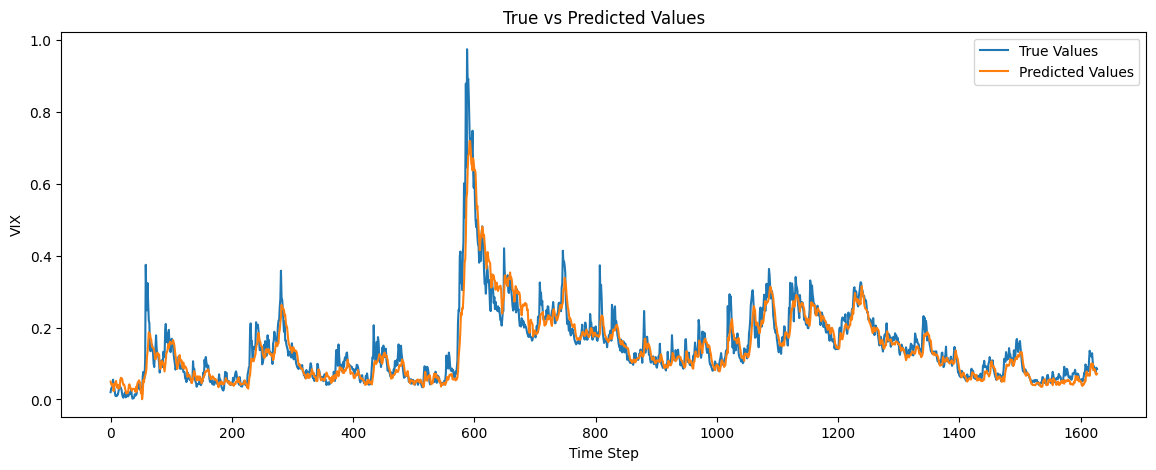

In [13]:
# Calculate loss (MSE) directly using Keras method for consistency
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss (MSE) from Keras evaluate: {loss[0]}')

# Optionally, plot the results for better visualization
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='True Values')
plt.plot(predictions_inv, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('VIX')
plt.legend()
plt.show()

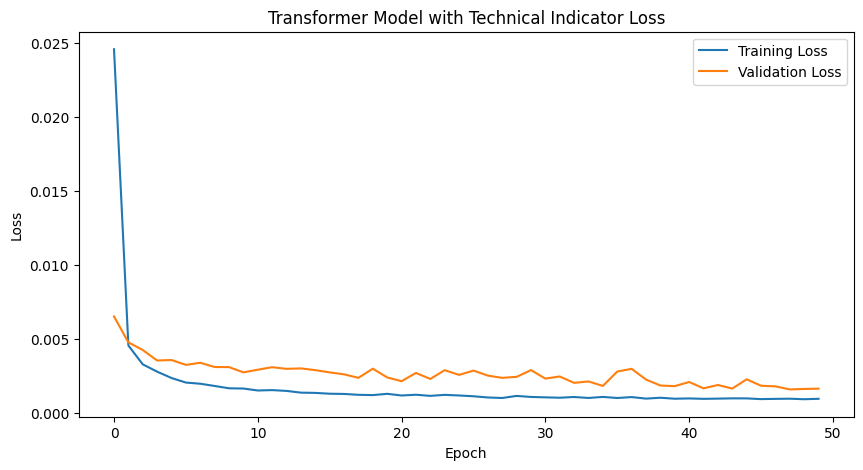

In [14]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model with Technical Indicator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [15]:
# 儲存模型參數
model.save('stock_price_prediction_model_0709_transformer_macd.h5')

In [16]:
# 訓練過程中的損失值
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# 輸出最高和最低的損失值
print("Highest Training Loss: ", max(training_loss))
print("Lowest Training Loss: ", min(training_loss))
print("Highest Validation Loss: ", max(validation_loss))
print("Lowest Validation Loss: ", min(validation_loss))

Highest Training Loss:  0.024578562006354332
Lowest Training Loss:  0.0009484955226071179
Highest Validation Loss:  0.006536457221955061
Lowest Validation Loss:  0.001611097832210362
